In [1]:
from glom import glom
import pandas as pd

import torch

import numpy as np
import matplotlib.pyplot as plt

from project import CreditDefault, NER, SkinCancer, set_seed

set_seed(1234)

print("CUDA is available:", torch.cuda.is_available())

CUDA is available: True


## Credit-card default

In [8]:
credit = CreditDefault()
credit.prepare_dataset("cuda")

In [11]:
optimizers = {
    "adamw": (torch.optim.AdamW, {"lr": 1e-4}),
    "rmsprop": (torch.optim.RMSprop, {"lr": 2e-5}),
    "adagrad": (torch.optim.Adagrad, {"lr": 1e-5}),
}

schedulers = {
    "linear": (torch.optim.lr_scheduler.LinearLR, {"start_factor": 1/3, "end_factor": 1/1000, "total_iters": 5}),
    "cosine": (torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, {"eta_min": 0, "T_0": 5}),
    "polynomial": (torch.optim.lr_scheduler.PolynomialLR, {"total_iters": 5, "power": 2})
}

In [18]:
df = credit.train(
    result_pickle = "data/credit.pkl", 
    optimizers = optimizers,
    schedulers = schedulers,
    epochs = 5,
    batch_size = 2000,
    device = "cuda",
    loss_func = torch.nn.BCELoss,
    shuffle = True
    )

-------------------------------------
|linear, adamw|
Epoch 1
	batch 1 | loss: 59.02404022216797 | accuracy: 0.595
	batch 2 | loss: 59.26552963256836 | accuracy: 0.6005
	batch 3 | loss: 57.26115798950195 | accuracy: 0.5805
	batch 4 | loss: 57.86546325683594 | accuracy: 0.5820000000000001
	batch 5 | loss: 56.67333984375 | accuracy: 0.5745
	batch 6 | loss: 56.5140380859375 | accuracy: 0.5725
	batch 7 | loss: 55.34188461303711 | accuracy: 0.5605
	batch 8 | loss: 52.97568893432617 | accuracy: 0.5429999999999999
	batch 9 | loss: 50.281768798828125 | accuracy: 0.5135000000000001
	batch 10 | loss: 48.30096435546875 | accuracy: 0.506
	batch 11 | loss: 43.5986213684082 | accuracy: 0.5465
	batch 12 | loss: 31.46444320678711 | accuracy: 0.6405
	batch 1 | loss: 21.473939895629883 | accuracy: 0.769
	batch 2 | loss: 20.27910041809082 | accuracy: 0.775
	batch 3 | loss: 20.78253936767578 | accuracy: 0.773
	Average accuracy 0.7723333333333334
Epoch 2
	batch 1 | loss: 20.432626724243164 | accuracy: 0.77

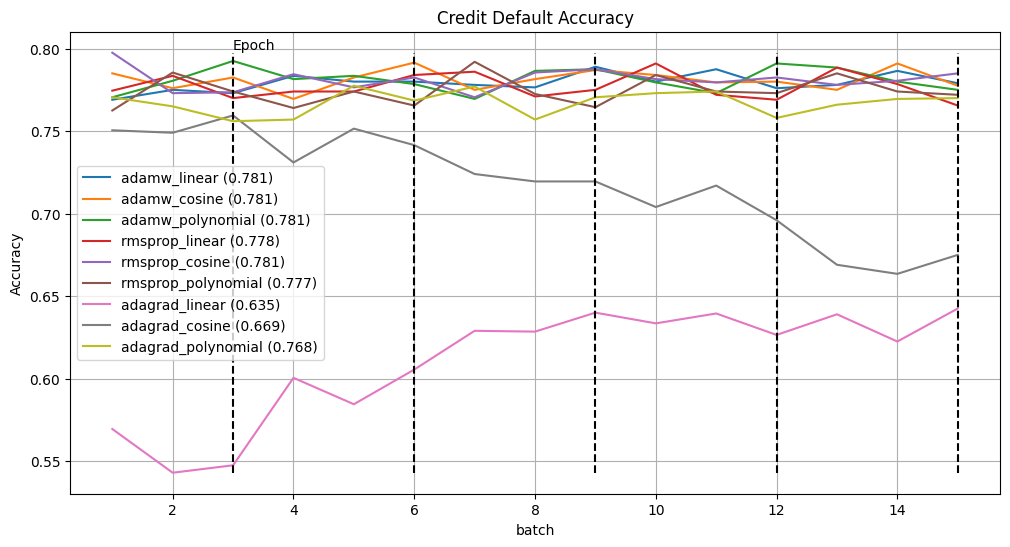

In [19]:
df = pd.read_pickle("data/credit.pkl")

plt.figure(figsize = (12,6))

_min = 1
_max = 0

for optim in df.index:
    for sched in df.columns:
        tpr,fpr, _ = dict(df.at[optim, sched])["roc_auc"]
        
        acc = np.array(df.at[optim, sched]["test_accuracy"]).flatten()
        if min(acc) < _min:
            _min = min(acc)
            
        if max(acc) > _max:
            _max = max(acc)
        
        plt.plot(np.arange(1,len(acc)+1), acc, label = f"{optim}_{sched} ({round(df.at[optim, sched]['accuracy'],3)})")

plt.vlines(
    [3*(i+1) for i in range(len(df.at[optim, sched]["test_accuracy"]))], 
    linestyles="--",
    color = "k", 
    ymin = _min, 
    ymax = _max
)
plt.text(3, _max+0.002, "Epoch")
    
        
plt.xlabel("batch")
plt.ylabel("Accuracy")
plt.title("Credit Default Accuracy")
plt.legend()
plt.grid()
plt.savefig("data/credit.png")
plt.show()

## NER

In [20]:
model_path = "distilbert/distilroberta-base"

ner = NER()
ner.load_tokenizer(model_path)
ner.prepare_dataset()

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [23]:
optimizers = {
    "adamw": (torch.optim.AdamW, {"lr": 2e-4}),
    "rmsprop": (torch.optim.RMSprop, {"lr": 3e-5, "momentum": 0}),
    "adagrad": (torch.optim.Adagrad, {"lr": 2.5e-4}),
}

schedulers = {
    "linear": {"num_warmup_steps": 0},
    "cosine_with_restarts": {"num_warmup_steps": 0, "num_cycles": 2},
    "polynomial": {"num_warmup_steps": 0, "power": 2}
}

In [24]:
df = ner.train(
    output_dir = "models/ner",
    optimizers = optimizers,
    schedulers = schedulers,
    tokenizer_path = model_path,
    model_path = model_path,
    strategy = "epoch",
    epochs = 8,
    batch_size = 150,
    result_pickle = "data/ner.pkl",
    device = "cuda"
)

----------------------------
Optimizer: adamw | Scheduler: linear


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.07149360328912735, 'eval_precision': 0.9123929613249271, 'eval_recall': 0.915753683415187, 'eval_f1': 0.9140702333254773, 'eval_accuracy': 0.9795188855819091, 'eval_runtime': 4.0528, 'eval_samples_per_second': 801.917, 'eval_steps_per_second': 5.428, 'epoch': 1.0}
{'eval_loss': 0.06182316318154335, 'eval_precision': 0.9290256218440247, 'eval_recall': 0.9383264072534945, 'eval_f1': 0.9336528521755474, 'eval_accuracy': 0.984121383203952, 'eval_runtime': 3.8869, 'eval_samples_per_second': 836.143, 'eval_steps_per_second': 5.66, 'epoch': 2.0}
{'eval_loss': 0.05916792154312134, 'eval_precision': 0.9395383609008504, 'eval_recall': 0.94956554590102, 'eval_f1': 0.944525341725774, 'eval_accuracy': 0.9858549906415882, 'eval_runtime': 3.8214, 'eval_samples_per_second': 850.47, 'eval_steps_per_second': 5.757, 'epoch': 3.0}
{'eval_loss': 0.06378686428070068, 'eval_precision': 0.9366388602493204, 'eval_recall': 0.9438043067623725, 'eval_f1': 0.9402079315049159, 'eval_accuracy': 0.986

Checkpoint destination directory models/ner/adamw_linear\checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'loss': 0.0607, 'grad_norm': 0.0741133987903595, 'learning_rate': 6.631016042780749e-05, 'epoch': 5.32}
{'eval_loss': 0.06214119866490364, 'eval_precision': 0.941661204232606, 'eval_recall': 0.9497544389875331, 'eval_f1': 0.9456905064183946, 'eval_accuracy': 0.9861771654751311, 'eval_runtime': 4.1742, 'eval_samples_per_second': 778.588, 'eval_steps_per_second': 5.27, 'epoch': 6.0}
{'eval_loss': 0.06325259804725647, 'eval_precision': 0.9440970601959869, 'eval_recall': 0.955421231582924, 'eval_f1': 0.9497253907900296, 'eval_accuracy': 0.9874198398330828, 'eval_runtime': 3.915, 'eval_samples_per_second': 830.14, 'eval_steps_per_second': 5.619, 'epoch': 7.0}
{'eval_loss': 0.06390991061925888, 'eval_precision': 0.9457893261052435, 'eval_recall': 0.9557045712126936, 'eval_f1': 0.9507210973833795, 'eval_accuracy': 0.9876039397379645, 'eval_runtime': 3.8662, 'eval_samples_per_second': 840.627, 'eval_steps_per_second': 5.69, 'epoch': 8.0}
{'train_runtime': 154.6696, 'train_samples_per_second':

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.06612110137939453, 'eval_precision': 0.9201846965699209, 'eval_recall': 0.9222704948998867, 'eval_f1': 0.9212264150943396, 'eval_accuracy': 0.9807769015986009, 'eval_runtime': 3.9346, 'eval_samples_per_second': 826.013, 'eval_steps_per_second': 5.591, 'epoch': 1.0}
{'eval_loss': 0.056069571524858475, 'eval_precision': 0.934857999812541, 'eval_recall': 0.9420098224404987, 'eval_f1': 0.938420285082561, 'eval_accuracy': 0.9846890245773373, 'eval_runtime': 4.0259, 'eval_samples_per_second': 807.264, 'eval_steps_per_second': 5.465, 'epoch': 2.0}
{'eval_loss': 0.05609047785401344, 'eval_precision': 0.9400339430511031, 'eval_recall': 0.9416320362674726, 'eval_f1': 0.940832311031424, 'eval_accuracy': 0.9850418827283606, 'eval_runtime': 3.9076, 'eval_samples_per_second': 831.702, 'eval_steps_per_second': 5.63, 'epoch': 3.0}
{'eval_loss': 0.06047436594963074, 'eval_precision': 0.9356500562008243, 'eval_recall': 0.9434265205893464, 'eval_f1': 0.9395221971407073, 'eval_accuracy': 0

Checkpoint destination directory models/ner/adamw_cosine_with_restarts\checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'loss': 0.0659, 'grad_norm': 0.24110524356365204, 'learning_rate': 4.807281327057972e-05, 'epoch': 5.32}
{'eval_loss': 0.06433738023042679, 'eval_precision': 0.9307520476545048, 'eval_recall': 0.9444654325651681, 'eval_f1': 0.9375585974123383, 'eval_accuracy': 0.9846429996011169, 'eval_runtime': 4.0491, 'eval_samples_per_second': 802.641, 'eval_steps_per_second': 5.433, 'epoch': 6.0}
{'eval_loss': 0.06537559628486633, 'eval_precision': 0.9330774990640209, 'eval_recall': 0.9415375897242161, 'eval_f1': 0.9372884543061301, 'eval_accuracy': 0.9844742413549753, 'eval_runtime': 3.9062, 'eval_samples_per_second': 832.02, 'eval_steps_per_second': 5.632, 'epoch': 7.0}
{'eval_loss': 0.06267211586236954, 'eval_precision': 0.9397017707362535, 'eval_recall': 0.952304495655459, 'eval_f1': 0.9459611595834506, 'eval_accuracy': 0.9864686569911939, 'eval_runtime': 3.9445, 'eval_samples_per_second': 823.936, 'eval_steps_per_second': 5.577, 'epoch': 8.0}
{'train_runtime': 154.4379, 'train_samples_per_sec

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.06652389466762543, 'eval_precision': 0.9181518151815181, 'eval_recall': 0.9196259916887042, 'eval_f1': 0.9188883121785495, 'eval_accuracy': 0.9803780184713571, 'eval_runtime': 3.8671, 'eval_samples_per_second': 840.422, 'eval_steps_per_second': 5.689, 'epoch': 1.0}
{'eval_loss': 0.0600784532725811, 'eval_precision': 0.929465620328849, 'eval_recall': 0.9396486588590858, 'eval_f1': 0.9345294007138832, 'eval_accuracy': 0.9844742413549753, 'eval_runtime': 3.8928, 'eval_samples_per_second': 834.867, 'eval_steps_per_second': 5.651, 'epoch': 2.0}
{'eval_loss': 0.05523807555437088, 'eval_precision': 0.9412540011297308, 'eval_recall': 0.9442765394786551, 'eval_f1': 0.9427628477133428, 'eval_accuracy': 0.9854714491730846, 'eval_runtime': 3.8679, 'eval_samples_per_second': 840.248, 'eval_steps_per_second': 5.688, 'epoch': 3.0}
{'eval_loss': 0.05774400010704994, 'eval_precision': 0.9432200224131491, 'eval_recall': 0.9539100868908198, 'eval_f1': 0.9485349361382419, 'eval_accuracy': 

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.07927603274583817, 'eval_precision': 0.8933542261959627, 'eval_recall': 0.915375897242161, 'eval_f1': 0.9042310024723609, 'eval_accuracy': 0.9772483200883679, 'eval_runtime': 4.0048, 'eval_samples_per_second': 811.52, 'eval_steps_per_second': 5.493, 'epoch': 1.0}
{'eval_loss': 0.05970894545316696, 'eval_precision': 0.9275497803122371, 'eval_recall': 0.9370986021911598, 'eval_f1': 0.9322997416020673, 'eval_accuracy': 0.9829093921634807, 'eval_runtime': 3.9508, 'eval_samples_per_second': 822.608, 'eval_steps_per_second': 5.568, 'epoch': 2.0}
{'eval_loss': 0.053309354931116104, 'eval_precision': 0.9318181818181818, 'eval_recall': 0.9448432187381942, 'eval_f1': 0.938285499906209, 'eval_accuracy': 0.9847964161885183, 'eval_runtime': 3.992, 'eval_samples_per_second': 814.129, 'eval_steps_per_second': 5.511, 'epoch': 3.0}
{'eval_loss': 0.05569922924041748, 'eval_precision': 0.9362299840809064, 'eval_recall': 0.9442765394786551, 'eval_f1': 0.940236046456952, 'eval_accuracy': 0.

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.07960394769906998, 'eval_precision': 0.8931608133086876, 'eval_recall': 0.9127313940309785, 'eval_f1': 0.9028400597907325, 'eval_accuracy': 0.9771562701359271, 'eval_runtime': 3.8687, 'eval_samples_per_second': 840.081, 'eval_steps_per_second': 5.687, 'epoch': 1.0}
{'eval_loss': 0.07086428254842758, 'eval_precision': 0.9056288315065948, 'eval_recall': 0.920853796751039, 'eval_f1': 0.913177858949143, 'eval_accuracy': 0.9790739774784449, 'eval_runtime': 4.079, 'eval_samples_per_second': 796.762, 'eval_steps_per_second': 5.393, 'epoch': 2.0}
{'eval_loss': 0.05644816532731056, 'eval_precision': 0.9245493402713251, 'eval_recall': 0.9397431054023423, 'eval_f1': 0.9320843091334895, 'eval_accuracy': 0.9836304501242674, 'eval_runtime': 3.8756, 'eval_samples_per_second': 838.578, 'eval_steps_per_second': 5.677, 'epoch': 3.0}
{'eval_loss': 0.056201767176389694, 'eval_precision': 0.9252771825211963, 'eval_recall': 0.9379486210804685, 'eval_f1': 0.9315698137986025, 'eval_accuracy': 

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.08012349903583527, 'eval_precision': 0.8901088761764163, 'eval_recall': 0.9111258027956177, 'eval_f1': 0.9004947260337907, 'eval_accuracy': 0.9768187536436439, 'eval_runtime': 6.8805, 'eval_samples_per_second': 472.347, 'eval_steps_per_second': 3.197, 'epoch': 1.0}
{'eval_loss': 0.05984228476881981, 'eval_precision': 0.9245441795231416, 'eval_recall': 0.9338874197204382, 'eval_f1': 0.9291923131137527, 'eval_accuracy': 0.9826639256236385, 'eval_runtime': 3.8831, 'eval_samples_per_second': 836.969, 'eval_steps_per_second': 5.666, 'epoch': 2.0}
{'eval_loss': 0.054044634103775024, 'eval_precision': 0.9293305985455902, 'eval_recall': 0.9414431431809596, 'eval_f1': 0.9353476588158018, 'eval_accuracy': 0.9840906998864717, 'eval_runtime': 3.9434, 'eval_samples_per_second': 824.157, 'eval_steps_per_second': 5.579, 'epoch': 3.0}
{'eval_loss': 0.0546758659183979, 'eval_precision': 0.9293437733035048, 'eval_recall': 0.9416320362674726, 'eval_f1': 0.9354475511352974, 'eval_accuracy'

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.07984671741724014, 'eval_precision': 0.8954036807546472, 'eval_recall': 0.9144314318095957, 'eval_f1': 0.9048175318910331, 'eval_accuracy': 0.9772636617471081, 'eval_runtime': 3.9934, 'eval_samples_per_second': 813.834, 'eval_steps_per_second': 5.509, 'epoch': 1.0}
{'eval_loss': 0.05991314351558685, 'eval_precision': 0.9227687721259549, 'eval_recall': 0.9354930109557991, 'eval_f1': 0.9290873276428102, 'eval_accuracy': 0.9825872173299377, 'eval_runtime': 3.8661, 'eval_samples_per_second': 840.632, 'eval_steps_per_second': 5.69, 'epoch': 2.0}
{'eval_loss': 0.05597136169672012, 'eval_precision': 0.9284646992902503, 'eval_recall': 0.9389875330562901, 'eval_f1': 0.9336964688204359, 'eval_accuracy': 0.9839372832990703, 'eval_runtime': 3.8661, 'eval_samples_per_second': 840.634, 'eval_steps_per_second': 5.69, 'epoch': 3.0}
{'eval_loss': 0.054473474621772766, 'eval_precision': 0.926817928212758, 'eval_recall': 0.941348696637703, 'eval_f1': 0.9340268016118451, 'eval_accuracy': 0

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.07952559739351273, 'eval_precision': 0.8978683966635774, 'eval_recall': 0.9149981110691349, 'eval_f1': 0.9063523248199082, 'eval_accuracy': 0.9778466447792336, 'eval_runtime': 3.9425, 'eval_samples_per_second': 824.346, 'eval_steps_per_second': 5.58, 'epoch': 1.0}
{'eval_loss': 0.07401536405086517, 'eval_precision': 0.9037477913140519, 'eval_recall': 0.9178315073668304, 'eval_f1': 0.91073520453587, 'eval_accuracy': 0.9788591942560829, 'eval_runtime': 3.9291, 'eval_samples_per_second': 827.17, 'eval_steps_per_second': 5.599, 'epoch': 2.0}
{'eval_loss': 0.06130542606115341, 'eval_precision': 0.9190068811604984, 'eval_recall': 0.9334151870041556, 'eval_f1': 0.9261549995314402, 'eval_accuracy': 0.982510509036237, 'eval_runtime': 3.8669, 'eval_samples_per_second': 840.466, 'eval_steps_per_second': 5.689, 'epoch': 3.0}
{'eval_loss': 0.05914533883333206, 'eval_precision': 0.9220174948818165, 'eval_recall': 0.9357763505855685, 'eval_f1': 0.9288459735633262, 'eval_accuracy': 0.9

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.08046621829271317, 'eval_precision': 0.8963284934800703, 'eval_recall': 0.915375897242161, 'eval_f1': 0.9057520676603896, 'eval_accuracy': 0.9773403700408088, 'eval_runtime': 3.9366, 'eval_samples_per_second': 825.582, 'eval_steps_per_second': 5.589, 'epoch': 1.0}
{'eval_loss': 0.061990853399038315, 'eval_precision': 0.9217277731131636, 'eval_recall': 0.9331318473743861, 'eval_f1': 0.9273947528981087, 'eval_accuracy': 0.9824644840600165, 'eval_runtime': 3.9847, 'eval_samples_per_second': 815.618, 'eval_steps_per_second': 5.521, 'epoch': 2.0}
{'eval_loss': 0.0579976961016655, 'eval_precision': 0.9264417235255631, 'eval_recall': 0.9361541367585946, 'eval_f1': 0.9312726076948372, 'eval_accuracy': 0.9834156669019054, 'eval_runtime': 3.9459, 'eval_samples_per_second': 823.649, 'eval_steps_per_second': 5.575, 'epoch': 3.0}
{'eval_loss': 0.05649198219180107, 'eval_precision': 0.9253884082240208, 'eval_recall': 0.9394597657725727, 'eval_f1': 0.9323709987345925, 'eval_accuracy':

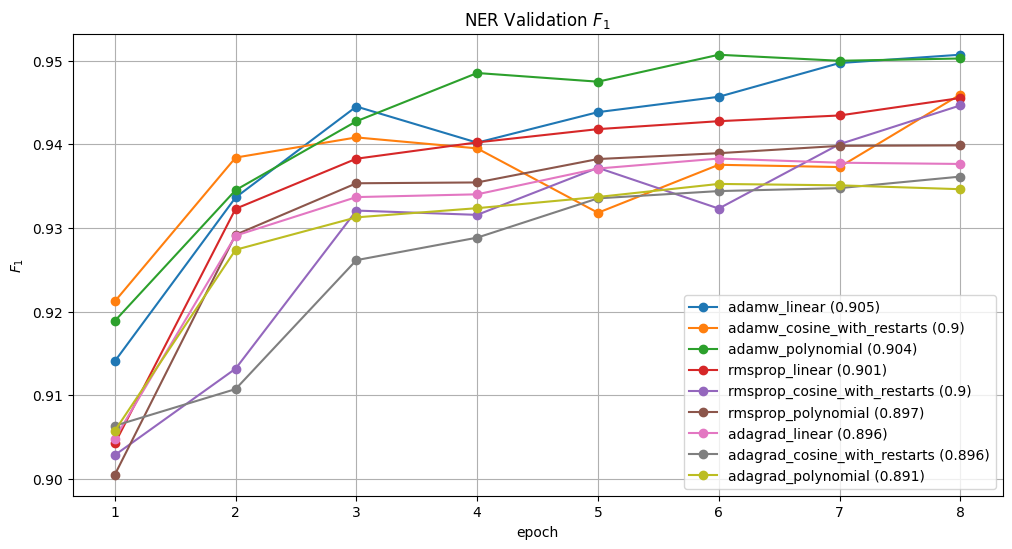

In [2]:
df = pd.read_pickle("data/ner.pkl")

plt.figure(figsize = (12,6))

for optim in df.index:
    for sched in df.columns:
        
        acc = glom(df.at[optim, sched]["log"], "*.eval_f1")
        
        plt.plot(np.arange(1,len(acc)+1),acc,"o-", label = f"{optim}_{sched} ({round(df.at[optim, sched]['overall_f1'],3)})")
    
        
plt.xlabel("epoch")
plt.ylabel("$F_1$")
plt.title("NER Validation $F_1$")
plt.legend()
plt.grid()
plt.savefig("data/ner.png")
plt.show()

## Melanoma identification

In [26]:
torch.cuda.empty_cache()

In [27]:
skincancer_model_path = "apple/mobilevit-small"

skin_cancer = SkinCancer()
skin_cancer.load_image_processor(skincancer_model_path)
skin_cancer.prepare_dataset()

In [30]:
optimizers = {
    "adamw": (torch.optim.AdamW, {"lr": 1e-4}),
    "rmsprop": (torch.optim.RMSprop, {"lr": 3e-5, "momentum": 0}),
    "adagrad": (torch.optim.Adagrad, {"lr": 2.5e-4}),
}

schedulers = {
    "linear": {"num_warmup_steps": 0},
    "cosine_with_restarts": {"num_warmup_steps": 0, "num_cycles": 2},
    "polynomial": {"num_warmup_steps": 0, "power": 2}
}

In [31]:
df = skin_cancer.train(
    output_dir = "models/skin_lesion/",
    result_pickle = "data/skin_lesion.pkl",
    optimizers = optimizers,
    schedulers = schedulers,
    image_processor_path= skincancer_model_path,
    model_path = skincancer_model_path,
    epochs = 6,
    batch_size = 80,
    strategy="epoch",
    device = "cuda"
)

----------------------------
Optimizer: adamw | Scheduler: linear


Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([7, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.9538292288780212, 'eval_accuracy': 0.7038523274478331, 'eval_runtime': 30.9274, 'eval_samples_per_second': 80.576, 'eval_steps_per_second': 1.035, 'epoch': 1.0}
{'eval_loss': 0.8513314127922058, 'eval_accuracy': 0.7030497592295345, 'eval_runtime': 32.0008, 'eval_samples_per_second': 77.873, 'eval_steps_per_second': 1.0, 'epoch': 2.0}
{'eval_loss': 0.7884140014648438, 'eval_accuracy': 0.7271268057784912, 'eval_runtime': 32.0192, 'eval_samples_per_second': 77.828, 'eval_steps_per_second': 0.999, 'epoch': 3.0}
{'eval_loss': 0.7437962889671326, 'eval_accuracy': 0.7471910112359551, 'eval_runtime': 31.3371, 'eval_samples_per_second': 79.522, 'eval_steps_per_second': 1.021, 'epoch': 4.0}
{'loss': 0.9695, 'grad_norm': 4.278258800506592, 'learning_rate': 3.036211699164346e-05, 'epoch': 4.17}
{'eval_loss': 0.7311694025993347, 'eval_accuracy': 0.7495987158908507, 'eval_runtime': 31.6053, 'eval_samples_per_second': 78.848, 'eval_steps_per_second': 1.012, 'epoch': 5.0}
{'eval_loss':

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([7, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.9947952628135681, 'eval_accuracy': 0.7046548956661316, 'eval_runtime': 31.3824, 'eval_samples_per_second': 79.408, 'eval_steps_per_second': 1.02, 'epoch': 1.0}
{'eval_loss': 0.8626017570495605, 'eval_accuracy': 0.7098715890850722, 'eval_runtime': 31.4, 'eval_samples_per_second': 79.363, 'eval_steps_per_second': 1.019, 'epoch': 2.0}
{'eval_loss': 0.8385633826255798, 'eval_accuracy': 0.7118780096308186, 'eval_runtime': 31.3969, 'eval_samples_per_second': 79.371, 'eval_steps_per_second': 1.019, 'epoch': 3.0}
{'eval_loss': 0.7838357090950012, 'eval_accuracy': 0.7263242375601926, 'eval_runtime': 31.0695, 'eval_samples_per_second': 80.207, 'eval_steps_per_second': 1.03, 'epoch': 4.0}
{'loss': 1.0007, 'grad_norm': 4.533151626586914, 'learning_rate': 6.652870207679252e-05, 'epoch': 4.17}
{'eval_loss': 0.7318751215934753, 'eval_accuracy': 0.7455858747993579, 'eval_runtime': 31.0498, 'eval_samples_per_second': 80.258, 'eval_steps_per_second': 1.031, 'epoch': 5.0}
{'eval_loss': 0.

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([7, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.0124646425247192, 'eval_accuracy': 0.7070626003210273, 'eval_runtime': 31.1071, 'eval_samples_per_second': 80.11, 'eval_steps_per_second': 1.029, 'epoch': 1.0}
{'eval_loss': 0.8678359389305115, 'eval_accuracy': 0.709470304975923, 'eval_runtime': 31.2392, 'eval_samples_per_second': 79.771, 'eval_steps_per_second': 1.024, 'epoch': 2.0}
{'eval_loss': 0.8145812749862671, 'eval_accuracy': 0.721107544141252, 'eval_runtime': 30.9122, 'eval_samples_per_second': 80.615, 'eval_steps_per_second': 1.035, 'epoch': 3.0}
{'eval_loss': 0.7936416268348694, 'eval_accuracy': 0.7255216693418941, 'eval_runtime': 30.6364, 'eval_samples_per_second': 81.341, 'eval_steps_per_second': 1.045, 'epoch': 4.0}
{'loss': 1.0079, 'grad_norm': 3.3559300899505615, 'learning_rate': 9.309362900660298e-06, 'epoch': 4.17}
{'eval_loss': 0.7959502339363098, 'eval_accuracy': 0.7215088282504013, 'eval_runtime': 30.7642, 'eval_samples_per_second': 81.003, 'eval_steps_per_second': 1.04, 'epoch': 5.0}
{'eval_loss': 

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([7, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.2520562410354614, 'eval_accuracy': 0.6978330658105939, 'eval_runtime': 30.579, 'eval_samples_per_second': 81.494, 'eval_steps_per_second': 1.046, 'epoch': 1.0}
{'eval_loss': 1.0053702592849731, 'eval_accuracy': 0.6998394863563403, 'eval_runtime': 30.4502, 'eval_samples_per_second': 81.838, 'eval_steps_per_second': 1.051, 'epoch': 2.0}
{'eval_loss': 0.928075909614563, 'eval_accuracy': 0.7050561797752809, 'eval_runtime': 30.446, 'eval_samples_per_second': 81.85, 'eval_steps_per_second': 1.051, 'epoch': 3.0}
{'eval_loss': 0.8896520733833313, 'eval_accuracy': 0.7110754414125201, 'eval_runtime': 30.1723, 'eval_samples_per_second': 82.592, 'eval_steps_per_second': 1.061, 'epoch': 4.0}
{'loss': 1.1338, 'grad_norm': 2.2999863624572754, 'learning_rate': 9.108635097493037e-06, 'epoch': 4.17}
{'eval_loss': 0.8830146193504333, 'eval_accuracy': 0.7078651685393258, 'eval_runtime': 30.486, 'eval_samples_per_second': 81.743, 'eval_steps_per_second': 1.05, 'epoch': 5.0}
{'eval_loss': 0.

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([7, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.2477469444274902, 'eval_accuracy': 0.6982343499197432, 'eval_runtime': 30.8444, 'eval_samples_per_second': 80.793, 'eval_steps_per_second': 1.037, 'epoch': 1.0}
{'eval_loss': 1.0512902736663818, 'eval_accuracy': 0.7006420545746388, 'eval_runtime': 30.6208, 'eval_samples_per_second': 81.383, 'eval_steps_per_second': 1.045, 'epoch': 2.0}
{'eval_loss': 1.0293526649475098, 'eval_accuracy': 0.7042536115569823, 'eval_runtime': 30.536, 'eval_samples_per_second': 81.609, 'eval_steps_per_second': 1.048, 'epoch': 3.0}
{'eval_loss': 0.9119522571563721, 'eval_accuracy': 0.7086677367576244, 'eval_runtime': 30.6872, 'eval_samples_per_second': 81.207, 'eval_steps_per_second': 1.043, 'epoch': 4.0}
{'loss': 1.1692, 'grad_norm': 2.1773059368133545, 'learning_rate': 1.9958610623037757e-05, 'epoch': 4.17}
{'eval_loss': 0.8876056671142578, 'eval_accuracy': 0.7026484751203852, 'eval_runtime': 30.4013, 'eval_samples_per_second': 81.97, 'eval_steps_per_second': 1.053, 'epoch': 5.0}
{'eval_loss

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([7, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.2916957139968872, 'eval_accuracy': 0.7006420545746388, 'eval_runtime': 31.2219, 'eval_samples_per_second': 79.816, 'eval_steps_per_second': 1.025, 'epoch': 1.0}
{'eval_loss': 1.0622566938400269, 'eval_accuracy': 0.6998394863563403, 'eval_runtime': 31.031, 'eval_samples_per_second': 80.307, 'eval_steps_per_second': 1.031, 'epoch': 2.0}
{'eval_loss': 0.9901170134544373, 'eval_accuracy': 0.7034510433386838, 'eval_runtime': 31.4325, 'eval_samples_per_second': 79.281, 'eval_steps_per_second': 1.018, 'epoch': 3.0}
{'eval_loss': 0.9612098336219788, 'eval_accuracy': 0.7082664526484751, 'eval_runtime': 31.0507, 'eval_samples_per_second': 80.256, 'eval_steps_per_second': 1.031, 'epoch': 4.0}
{'loss': 1.184, 'grad_norm': 1.8364369869232178, 'learning_rate': 2.8563558631605894e-06, 'epoch': 4.17}
{'eval_loss': 0.9571002125740051, 'eval_accuracy': 0.706661316211878, 'eval_runtime': 31.323, 'eval_samples_per_second': 79.558, 'eval_steps_per_second': 1.022, 'epoch': 5.0}
{'eval_loss':

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([7, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.432186484336853, 'eval_accuracy': 0.6930176565008026, 'eval_runtime': 31.0341, 'eval_samples_per_second': 80.299, 'eval_steps_per_second': 1.031, 'epoch': 1.0}
{'eval_loss': 1.1983181238174438, 'eval_accuracy': 0.6982343499197432, 'eval_runtime': 31.3196, 'eval_samples_per_second': 79.567, 'eval_steps_per_second': 1.022, 'epoch': 2.0}
{'eval_loss': 1.1035808324813843, 'eval_accuracy': 0.7018459069020867, 'eval_runtime': 31.2684, 'eval_samples_per_second': 79.697, 'eval_steps_per_second': 1.023, 'epoch': 3.0}
{'eval_loss': 1.059706449508667, 'eval_accuracy': 0.7042536115569823, 'eval_runtime': 31.3556, 'eval_samples_per_second': 79.476, 'eval_steps_per_second': 1.021, 'epoch': 4.0}
{'loss': 1.2981, 'grad_norm': 1.799654483795166, 'learning_rate': 7.590529247910864e-05, 'epoch': 4.17}
{'eval_loss': 1.0398138761520386, 'eval_accuracy': 0.709470304975923, 'eval_runtime': 31.8457, 'eval_samples_per_second': 78.252, 'eval_steps_per_second': 1.005, 'epoch': 5.0}
{'eval_loss': 

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([7, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.4273468255996704, 'eval_accuracy': 0.6966292134831461, 'eval_runtime': 31.0672, 'eval_samples_per_second': 80.213, 'eval_steps_per_second': 1.03, 'epoch': 1.0}
{'eval_loss': 1.2521355152130127, 'eval_accuracy': 0.6990369181380417, 'eval_runtime': 30.8079, 'eval_samples_per_second': 80.888, 'eval_steps_per_second': 1.039, 'epoch': 2.0}
{'eval_loss': 1.2310636043548584, 'eval_accuracy': 0.7034510433386838, 'eval_runtime': 30.7121, 'eval_samples_per_second': 81.141, 'eval_steps_per_second': 1.042, 'epoch': 3.0}
{'eval_loss': 1.1115607023239136, 'eval_accuracy': 0.702247191011236, 'eval_runtime': 30.9099, 'eval_samples_per_second': 80.621, 'eval_steps_per_second': 1.035, 'epoch': 4.0}
{'loss': 1.347, 'grad_norm': 1.7353442907333374, 'learning_rate': 0.0001663217551919813, 'epoch': 4.17}
{'eval_loss': 1.0631568431854248, 'eval_accuracy': 0.7062600321027287, 'eval_runtime': 30.5248, 'eval_samples_per_second': 81.638, 'eval_steps_per_second': 1.048, 'epoch': 5.0}
{'eval_loss':

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([7, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.4684643745422363, 'eval_accuracy': 0.692215088282504, 'eval_runtime': 31.1202, 'eval_samples_per_second': 80.077, 'eval_steps_per_second': 1.028, 'epoch': 1.0}
{'eval_loss': 1.2739375829696655, 'eval_accuracy': 0.6982343499197432, 'eval_runtime': 31.1105, 'eval_samples_per_second': 80.101, 'eval_steps_per_second': 1.029, 'epoch': 2.0}
{'eval_loss': 1.2032161951065063, 'eval_accuracy': 0.702247191011236, 'eval_runtime': 31.1699, 'eval_samples_per_second': 79.949, 'eval_steps_per_second': 1.027, 'epoch': 3.0}
{'eval_loss': 1.179463505744934, 'eval_accuracy': 0.7014446227929374, 'eval_runtime': 31.0901, 'eval_samples_per_second': 80.154, 'eval_steps_per_second': 1.029, 'epoch': 4.0}
{'loss': 1.3682, 'grad_norm': 2.044772148132324, 'learning_rate': 2.3137235123873956e-05, 'epoch': 4.17}
{'eval_loss': 1.1690489053726196, 'eval_accuracy': 0.7018459069020867, 'eval_runtime': 31.191, 'eval_samples_per_second': 79.895, 'eval_steps_per_second': 1.026, 'epoch': 5.0}
{'eval_loss': 

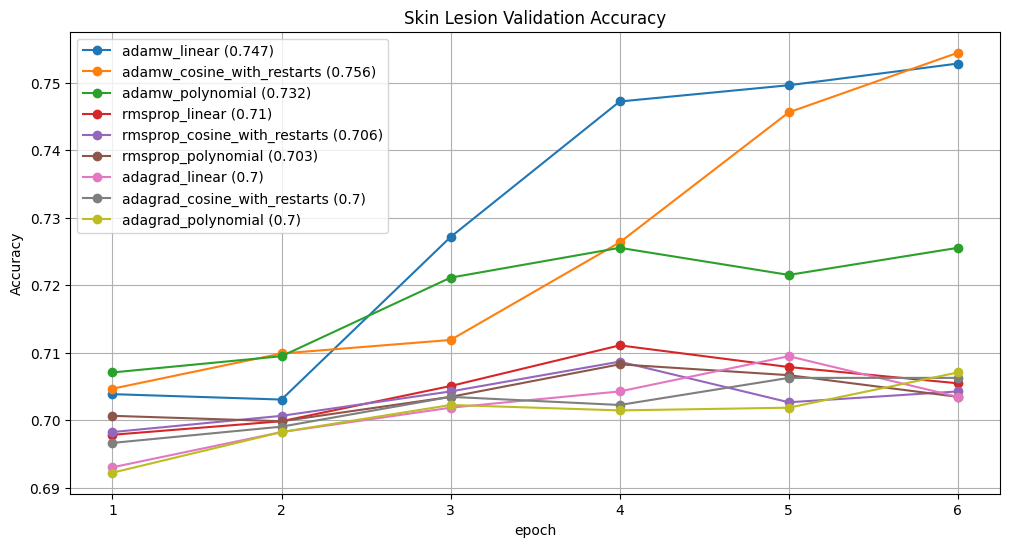

In [3]:
df = pd.read_pickle("data/skin_lesion.pkl")

plt.figure(figsize = (12,6))

for optim in df.index:
    for sched in df.columns:
        
        acc = glom(df.at[optim, sched]["log"], "*.eval_accuracy")
        
        plt.plot(np.arange(1,len(acc)+1),acc,"o-", label = f"{optim}_{sched} ({round(df.at[optim, sched]['accuracy'],3)})")
    
        
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.title("Skin Lesion Validation Accuracy")
plt.legend()
plt.grid()
plt.savefig("data/skin_lesion.png")
plt.show()